# Task 1

# 1) 환경 경로 설정 + 유틸

In [2]:
from pathlib import Path
import os, re, json, hashlib, logging
from typing import List, Dict
from datetime import datetime
from tqdm import tqdm
import pandas as pd
import pdfplumber

# ====== Paths ======
REPO_DIR   = Path("/home/bhs1581/rag-rfp-system").resolve()
PDF_DIR    = REPO_DIR / "data" / "pdf"          # 변환된 PDF가 있는 루트 폴더
OUT_DIR    = REPO_DIR / "outputs"
STRUCT_DIR = OUT_DIR / "structure_check"
LOG_DIR    = OUT_DIR / "logs"

for d in [STRUCT_DIR, LOG_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# ====== Logging ======
logging.basicConfig(
    filename=str(LOG_DIR / "task1_inventory.log"),
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s"
)

def sha1_of_file(p: Path, buf=1024*1024) -> str:
    h = hashlib.sha1()
    with open(p, "rb") as f:
        while True:
            b = f.read(buf)
            if not b:
                break
            h.update(b)
    return h.hexdigest()

def path_has_risky_chars(name: str) -> bool:
    # 공백 연속, 탭, 줄바꿈, 제어문자, 극단적 특수문자 등
    return bool(re.search(r"[\t\n\r]| {2,}|[<>:\"\\|?*]", name))

print({
    "REPO_DIR": str(REPO_DIR),
    "PDF_DIR": str(PDF_DIR),
    "OUT": str(STRUCT_DIR)
})


{'REPO_DIR': '/home/bhs1581/rag-rfp-system', 'PDF_DIR': '/home/bhs1581/rag-rfp-system/data/pdf', 'OUT': '/home/bhs1581/rag-rfp-system/outputs/structure_check'}


# 2) PDF 스캔 + 메타 수집 (페이지 수, 크기, 해시, 파일명 위험도)

In [23]:
pdf_files = sorted([p for p in PDF_DIR.rglob("*.pdf") if p.is_file()])
print(f"Found PDFs: {len(pdf_files)}")

rows = []
hash_first_path = {}

for p in tqdm(pdf_files, desc="Inventory PDFs"):
    try:
        size = p.stat().st_size
        mtime = datetime.fromtimestamp(p.stat().st_mtime).isoformat(timespec="seconds")
        sha1 = sha1_of_file(p)
        pages = -1
        producer = ""
        can_open = True
        try:
            with pdfplumber.open(p) as pdf:
                pages = len(pdf.pages)
                # PDF 메타의 Producer/Creator 일부 참고(없어도 무방)
                meta = pdf.metadata or {}
                producer = meta.get("Producer") or meta.get("Creator") or ""
        except Exception as e:
            can_open = False
            logging.info(f"OpenError | {p} | {e}")

        first_seen = hash_first_path.get(sha1)
        duplicate = (first_seen is not None and first_seen != str(p))

        rows.append({
            "path": str(p),
            "file_name": p.name,
            "dir": str(p.parent),
            "size_bytes": size,
            "modified": mtime,
            "pages": pages,
            "sha1": sha1,
            "duplicate": duplicate,
            "dup_of": first_seen if duplicate else "",
            "can_open": can_open,
            "producer": producer,
            "risky_filename": path_has_risky_chars(p.name)
        })
        if first_seen is None:
            hash_first_path[sha1] = str(p)
    except Exception as e:
        logging.info(f"InventoryError | {p} | {e}")

inv_df = pd.DataFrame(rows).sort_values(["duplicate","file_name"]).reset_index(drop=True)
inv_path = STRUCT_DIR / "pdf_inventory.csv"
inv_df.to_csv(inv_path, index=False, encoding="utf-8-sig")

dups_df = inv_df[inv_df["duplicate"]==True].copy()
dups_path = STRUCT_DIR / "duplicates.csv"
dups_df.to_csv(dups_path, index=False, encoding="utf-8-sig")

print(f"Saved: {inv_path}  |  Duplicates: {len(dups_df)}  |  Open errors: {(inv_df['can_open']==False).sum()}")
inv_df.head(10)


Found PDFs: 100


Inventory PDFs: 100%|██████████| 100/100 [00:07<00:00, 13.69it/s]

Saved: /home/bhs1581/rag-rfp-system/outputs/structure_check/pdf_inventory.csv  |  Duplicates: 0  |  Open errors: 0


,path,file_name,dir,size_bytes,modified,pages,sha1,duplicate,dup_of,can_open,producer,risky_filename
0,/home/bhs1581/rag-rfp-system/data/pdf/(사)벤ᄎ...,(사)벤처기업협회_2024년 벤처확인종합ᄀ...,/home/bhs1581/rag-rfp-system/data/pdf,2249981,2025-11-11T05:03:57,131,132a0a6da7c7b1543797ef82a02136df232bc8aa,False,,True,Hancom PDF 1.3.0.545,False
1,/home/bhs1581/rag-rfp-system/data/pdf/(사)부사...,(사)부산국제영화제_2024년 BIFF & ACFM 온ᄅ...,/home/bhs1581/rag-rfp-system/data/pdf,473834,2025-11-11T05:03:48,32,00afffdb1a276bbfa0dc99eba1e422b2d17f6b01,False,,True,Hancom PDF 1.3.0.545,False
2,/home/bhs1581/rag-rfp-system/data/pdf/(사）한ᄀ...,(사）한국대학스포츠협의회_KUSF 체육특기자...,/home/bhs1581/rag-rfp-system/data/pdf,1325778,2025-11-11T05:03:54,40,3132e4fe9b4f9fe19a178c8f2e2b9b36dd556dcd,False,,True,Hancom PDF 1.3.0.545,False
3,/home/bhs1581/rag-rfp-system/data/pdf/(재)예수...,(재)예술경영지원센터_통합 정보시스템 ...,/home/bhs1581/rag-rfp-system/data/pdf,857571,2025-11-11T05:03:49,29,dd0f6b2f6b5ec2c75de6d76de5f014658ec04473,False,,True,Hancom PDF 1.3.0.545,False
4,/home/bhs1581/rag-rfp-system/data/pdf/2025 구ᄆ...,2025 구미 아시아육상경기선수권대회 조직ᄋ...,/home/bhs1581/rag-rfp-system/data/pdf,883919,2025-11-11T05:03:49,63,56b0afece551e8d232b6aeb6ea77aa8fbbdd6d51,False,,True,Hancom PDF 1.3.0.545,False
5,/home/bhs1581/rag-rfp-system/data/pdf/BioIN_의...,BioIN_의료기기산업 종합정보시스템(정보ᄀ...,/home/bhs1581/rag-rfp-system/data/pdf,1430967,2025-11-11T05:03:57,48,cc7ffa9c7e7fb3c1795b9550369f5996c110e276,False,,True,Hancom PDF 1.3.0.545,False
6,/home/bhs1581/rag-rfp-system/data/pdf/KOICA 저...,KOICA 전자조달_[긴급] [지문] [국제] 우즈...,/home/bhs1581/rag-rfp-system/data/pdf,2936840,2025-11-11T05:03:58,154,0e30d7a8d511e37ff6a94ee1e2b4c5921e721466,False,,True,Hancom PDF 1.3.0.545,False
7,/home/bhs1581/rag-rfp-system/data/pdf/경기도 ...,경기도 안양시_호계체육관 배드민턴장 미...,/home/bhs1581/rag-rfp-system/data/pdf,1677737,2025-11-11T05:03:54,46,3e00aeafc497e44c025f8272272136201c7930d8,False,,True,Hancom PDF 1.3.0.545,False
8,/home/bhs1581/rag-rfp-system/data/pdf/경기도 ...,경기도 평택시_2024년도 평택시 버스정보ᄉ...,/home/bhs1581/rag-rfp-system/data/pdf,2179591,2025-11-11T05:03:57,118,b6d0f4d607b09c342f83b0bf181de4a53bb85360,False,,True,Hancom PDF 1.3.0.545,False
9,/home/bhs1581/rag-rfp-system/data/pdf/경기도ᄉ...,경기도사회서비스원_2024년 통합사회정보시...,/home/bhs1581/rag-rfp-system/data/pdf,1063380,2025-11-11T05:03:54,113,e42bb221222d5173d0cf8ebbb4ee86851da731f9,False,,True,Hancom PDF 1.3.0.545,False


# 3) “텍스트형 vs 스캔형” 간이 추정 (추출 길이 샘플링)

Task 2에서 실제 추출을 본격 수행하겠지만, Task 1에서는 비용을 아끼려고 1~2페이지만 얕게 확인해서 유형을 추정한다.

In [24]:
def quick_text_signal(p: Path, max_pages_check=2) -> Dict:
    """
    pdfplumber의 extract_text를 1~2페이지만 시도해
    '텍스트가 나오는지' 신호만 본다. (긴 추출/저장 없음)
    """
    sig = {"checked_pages": 0, "nonempty_pages": 0, "sample_chars": 0}
    try:
        with pdfplumber.open(p) as pdf:
            n = min(len(pdf.pages), max_pages_check)
            sig["checked_pages"] = n
            for i in range(n):
                try:
                    t = (pdf.pages[i].extract_text() or "").strip()
                    if t:
                        sig["nonempty_pages"] += 1
                        sig["sample_chars"] += len(t)
                except Exception as e:
                    logging.info(f"QuickExtractPageError | {p} | page={i+1} | {e}")
    except Exception as e:
        logging.info(f"QuickOpenError | {p} | {e}")
    return sig

quick_rows = []
for p in tqdm(pdf_files, desc="Quick text signals"):
    sig = quick_text_signal(p, max_pages_check=2)
    quick_rows.append({
        "path": str(p),
        "file_name": p.name,
        "quick_checked_pages": sig["checked_pages"],
        "quick_nonempty_pages": sig["nonempty_pages"],
        "quick_sample_chars": sig["sample_chars"],
        # 휴리스틱: 2페이지 모두 비었고 sample_chars=0이면 스캔형 '가능성 높음'
        "likely_scanned": (sig["checked_pages"]>0 and sig["nonempty_pages"]==0 and sig["sample_chars"]==0)
    })

quick_df = pd.DataFrame(quick_rows)
quick_path = STRUCT_DIR / "pdf_quick_scan.csv"
quick_df.to_csv(quick_path, index=False, encoding="utf-8-sig")
print(f"Saved: {quick_path}")
quick_df.head(10)


Quick text signals: 100%|██████████| 100/100 [01:08<00:00,  1.47it/s]

Saved: /home/bhs1581/rag-rfp-system/outputs/structure_check/pdf_quick_scan.csv


,path,file_name,quick_checked_pages,quick_nonempty_pages,quick_sample_chars,likely_scanned
0,/home/bhs1581/rag-rfp-system/data/pdf/(사)벤ᄎ...,(사)벤처기업협회_2024년 벤처확인종합ᄀ...,2,2,1126,False
1,/home/bhs1581/rag-rfp-system/data/pdf/(사)부사...,(사)부산국제영화제_2024년 BIFF & ACFM 온ᄅ...,2,2,2243,False
2,/home/bhs1581/rag-rfp-system/data/pdf/(사）한ᄀ...,(사）한국대학스포츠협의회_KUSF 체육특기자...,2,2,3480,False
3,/home/bhs1581/rag-rfp-system/data/pdf/(재)예수...,(재)예술경영지원센터_통합 정보시스템 ...,2,2,1316,False
4,/home/bhs1581/rag-rfp-system/data/pdf/2025 구ᄆ...,2025 구미 아시아육상경기선수권대회 조직ᄋ...,2,2,1351,False
5,/home/bhs1581/rag-rfp-system/data/pdf/BioIN_의...,BioIN_의료기기산업 종합정보시스템(정보ᄀ...,2,2,5355,False
6,/home/bhs1581/rag-rfp-system/data/pdf/KOICA 저...,KOICA 전자조달_[긴급] [지문] [국제] 우즈...,2,2,1809,False
7,/home/bhs1581/rag-rfp-system/data/pdf/경기도 ...,경기도 안양시_호계체육관 배드민턴장 미...,2,2,2018,False
8,/home/bhs1581/rag-rfp-system/data/pdf/경기도 ...,경기도 평택시_2024년도 평택시 버스정보ᄉ...,2,2,650,False
9,/home/bhs1581/rag-rfp-system/data/pdf/경기도ᄉ...,경기도사회서비스원_2024년 통합사회정보시...,2,2,2100,False


# 4) 위험/이상 항목 요약(리뷰용 스냅샷)

In [34]:
snap = {}

# 4-1. 열 수 없는 파일
cols_open = [c for c in ["file_name","path","pages","size_bytes"] if c in inv_df.columns]
snap["open_errors"] = inv_df[inv_df["can_open"]==False][cols_open].head(50)

# 4-2. 중복
cols_dup = [c for c in ["file_name","path","dup_of","size_bytes"] if c in dups_df.columns]
snap["duplicates"] = dups_df[cols_dup].head(50)

# 4-3. 페이지 수/용량 극단값
cols_large = [c for c in ["file_name","size_bytes","pages","path"] if c in inv_df.columns]
snap["largest_files"] = inv_df.sort_values("size_bytes", ascending=False)[cols_large].head(15)
snap["longest_docs"]  = inv_df.sort_values("pages", ascending=False)[cols_large].head(15)

# 4-4. 위험한 파일명
cols_risky = [c for c in ["file_name","path"] if c in inv_df.columns]
snap["risky_names"] = inv_df[inv_df["risky_filename"]==True][cols_risky].head(100)

# 4-5. 스캔형 가능성 높은 후보
merge_cols = [c for c in ["file_name","pages","size_bytes","path"] if c in inv_df.columns]
scan_df = quick_df.merge(inv_df[merge_cols], on="file_name", how="left")

cols_scan = [c for c in ["file_name","pages","size_bytes","path"] if c in scan_df.columns]
snap["likely_scanned"] = scan_df[scan_df["likely_scanned"]==True][cols_scan].head(100)

# 저장
with pd.ExcelWriter(STRUCT_DIR / "task1_review_snapshots.xlsx", engine="xlsxwriter") as w:
    for name, df in snap.items():
        df.to_excel(w, sheet_name=name[:31], index=False)

print("✅ Saved:", STRUCT_DIR / "task1_review_snapshots.xlsx")
{ k: v.shape for k,v in snap.items() }


✅ Saved: /home/bhs1581/rag-rfp-system/outputs/structure_check/task1_review_snapshots.xlsx


{'open_errors': (0, 4),
 'duplicates': (0, 4),
 'largest_files': (15, 4),
 'longest_docs': (15, 4),
 'risky_names': (4, 2),
 'likely_scanned': (0, 3)}

# 5) 빠른 합본 리포트

In [36]:
report_lines = []
report_lines.append("# Task 1 — PDF Inventory & Quality Check\n")
report_lines.append(f"- Total PDFs: **{len(inv_df)}**")
report_lines.append(f"- Duplicates: **{len(dups_df)}**")
report_lines.append(f"- Open errors: **{(inv_df['can_open']==False).sum()}**")

likely_scanned_cnt = int((quick_df["likely_scanned"]==True).sum())
report_lines.append(f"- Likely scanned (by quick check): **{likely_scanned_cnt}**")
report_lines.append("")
report_lines.append("### Files with risky names (first 10)\n")
report_lines.append(pd.DataFrame(inv_df[inv_df["risky_filename"]==True][["file_name","path"]].head(10)).to_markdown(index=False))
report_lines.append("\n### Largest files (by size) — top 10\n")
report_lines.append(pd.DataFrame(inv_df.sort_values("size_bytes", ascending=False)[["file_name","size_bytes","pages"]].head(10)).to_markdown(index=False))
report_lines.append("\n### Longest docs (by pages) — top 10\n")
report_lines.append(pd.DataFrame(inv_df.sort_values("pages", ascending=False)[["file_name","pages","size_bytes"]].head(10)).to_markdown(index=False))

save_md = STRUCT_DIR / "task1_report.md"
with open(save_md, "w", encoding="utf-8") as f:
    f.write("\n\n".join(report_lines))
print("Saved:", save_md)


Saved: /home/bhs1581/rag-rfp-system/outputs/structure_check/task1_report.md


In [37]:
from pathlib import Path
import pandas as pd

BASE_DIR = Path("/home/bhs1581/rag-rfp-system/outputs/structure_check")

print("📁 [Task1 결과물 점검]\n")

# 1️⃣ 파일 존재 여부
expected_files = [
    "pdf_inventory.csv",
    "text_extraction_summary.csv",
    "document_structure_report.csv",
    "pdf_quick_scan.csv",
    "duplicates.csv",
    "task1_report.md",
    "task1_review_snapshots.xlsx"
]

for f in expected_files:
    p = BASE_DIR / f
    status = "✅ 존재함" if p.exists() else "❌ 없음"
    print(f"{status:<8}  {f}")

# 2️⃣ 주요 CSV 파일 간단 통계
print("\n\n📊 [CSV 파일 샘플 요약]\n")

for f in BASE_DIR.glob("*.csv"):
    try:
        df = pd.read_csv(f)
        print(f"▶ {f.name}: {len(df)} rows × {len(df.columns)} cols")
        print(df.head(2))
        print("-" * 60)
    except Exception as e:
        print(f"⚠️ {f.name} 읽기 실패:", e)

# 3️⃣ Markdown 및 Excel 파일 존재 확인
for f in ["task1_report.md", "task1_review_snapshots.xlsx"]:
    p = BASE_DIR / f
    if p.exists():
        size_kb = round(p.stat().st_size / 1024, 1)
        print(f"📄 {f}  ({size_kb} KB)")


📁 [Task1 결과물 점검]

✅ 존재함     pdf_inventory.csv
✅ 존재함     text_extraction_summary.csv
✅ 존재함     document_structure_report.csv
✅ 존재함     pdf_quick_scan.csv
✅ 존재함     duplicates.csv
✅ 존재함     task1_report.md
✅ 존재함     task1_review_snapshots.xlsx


📊 [CSV 파일 샘플 요약]

▶ text_extraction_summary.csv: 100 rows × 4 cols
                                           file_name  char_count  used_ocr  \
0  한국지식재산보호원_IP-NAVI  해외지식재사...       51022     False   
1  한국사회보장정보원_라오스 보건의료정보ᄒ...       52064     False   

                                      sample_preview  
0  목 차 1. 사업개요···································...  
1  제 안 요 청 서 라오스 보건의료정보화 협력을 위한 사 업 명 사전타당성 조사 주관...  
------------------------------------------------------------
▶ pdf_inventory.csv: 100 rows × 12 cols
                                                path  \
0  /home/bhs1581/rag-rfp-system/data/pdf/(사)벤ᄎ...   
1  /home/bhs1581/rag-rfp-system/data/pdf/(사)부사...   

                   

# Task 2

문서 구조 분석 중: 100%|██████████| 100/100 [00:01<00:00, 69.05it/s]



✅ 구조 분석 결과 저장: /home/bhs1581/rag-rfp-system/outputs/structure_check/document_structure_report.csv


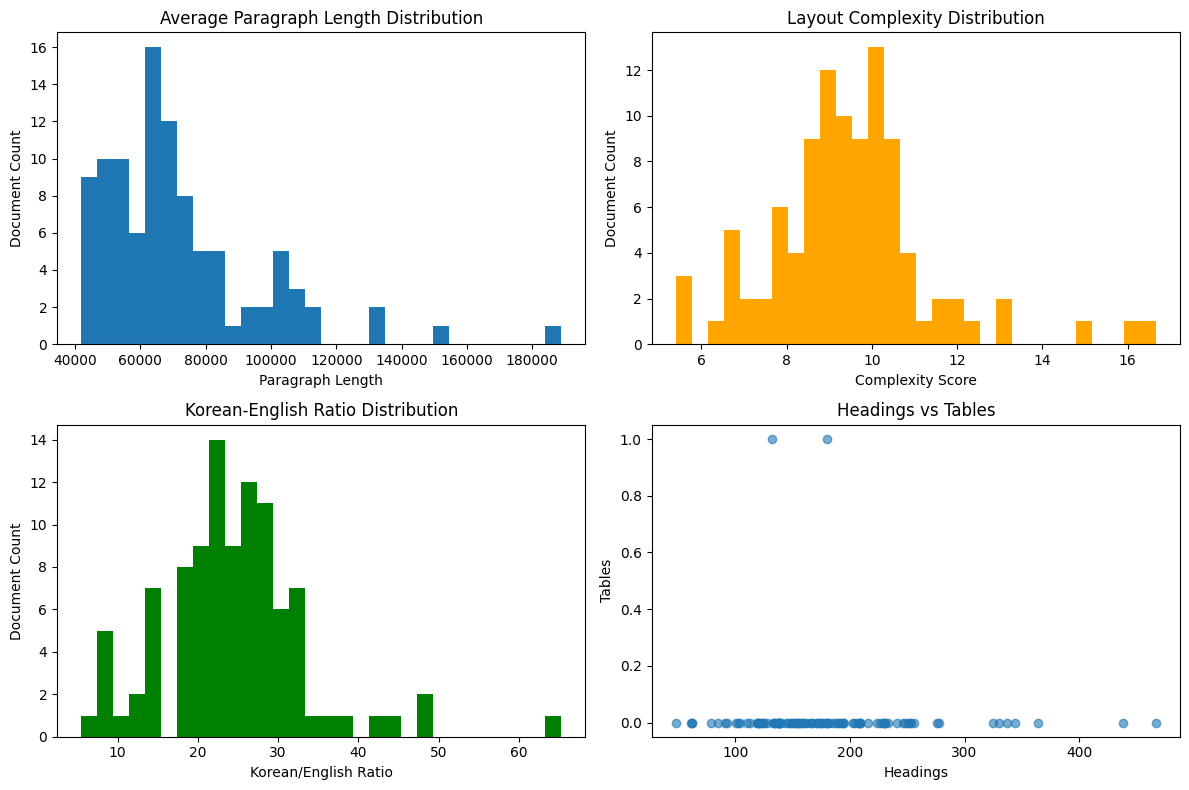

📊 시각화 그래프 저장: /home/bhs1581/rag-rfp-system/outputs/structure_check/structure_stats.png
🧾 Markdown 보고서 저장: /home/bhs1581/rag-rfp-system/outputs/structure_check/structure_patterns.md


In [42]:
# =========================================================
# 📘 02_document_structure_analysis.ipynb
# Purpose : Analyze paragraph / table / heading patterns with visualization
# =========================================================

import re
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

# ---------------------------------------------------------
# 1️⃣ 경로 설정
# ---------------------------------------------------------
STRUCT_DIR = Path("/home/bhs1581/rag-rfp-system/outputs/structure_check")
TXT_FILES = list(STRUCT_DIR.glob("*.txt"))

REPORT_PATH = STRUCT_DIR / "document_structure_report.csv"
MD_PATH = STRUCT_DIR / "structure_patterns.md"
PLOT_PATH = STRUCT_DIR / "structure_stats.png"

# ---------------------------------------------------------
# 2️⃣ 분석 함수 정의
# ---------------------------------------------------------
def analyze_structure(text):
    """텍스트 내 구조적 패턴 분석"""
    headings = len(re.findall(r"(^\d+[\.\)]|\b[Ⅰ-Ⅹ]+\.)", text, re.MULTILINE))
    tables = text.count("|") + text.count("\t")
    bullets = len(re.findall(r"(?:•|-|\*)\s", text))
    
    paragraphs = [p.strip() for p in text.split("\n\n") if len(p.strip()) > 0]
    avg_paragraph_len = sum(len(p) for p in paragraphs) / max(1, len(paragraphs))
    
    kor = len(re.findall(r"[가-힣]", text))
    eng = len(re.findall(r"[A-Za-z]", text))
    language_mix_ratio = round(kor / (eng + 1e-5), 3)
    
    layout_complexity = round((headings + tables + bullets) / max(1, len(text)) * 1000, 4)

    return {
        "headings": headings,
        "tables": tables,
        "bullets": bullets,
        "avg_paragraph_len": round(avg_paragraph_len, 2),
        "language_mix_ratio": language_mix_ratio,
        "layout_complexity": layout_complexity
    }

# ---------------------------------------------------------
# 3️⃣ 전체 문서 분석
# ---------------------------------------------------------
structure_data = []
for file in tqdm(TXT_FILES, desc="문서 구조 분석 중"):
    try:
        with open(file, encoding="utf-8") as f:
            text = f.read()
        result = analyze_structure(text)
        result["file_name"] = file.name
        result["text_length"] = len(text)
        structure_data.append(result)
    except Exception as e:
        print(f"⚠️ {file.name} 분석 실패:", e)

df = pd.DataFrame(structure_data)
df.to_csv(REPORT_PATH, index=False, encoding="utf-8-sig")
print(f"\n✅ 구조 분석 결과 저장: {REPORT_PATH}")

# ---------------------------------------------------------
# 4️⃣ 통계 시각화
# ---------------------------------------------------------
plt.figure(figsize=(12, 8))

# (1) 문단 평균 길이 분포
plt.subplot(2, 2, 1)
plt.hist(df["avg_paragraph_len"], bins=30)
plt.title("Average Paragraph Length Distribution")
plt.xlabel("Paragraph Length")
plt.ylabel("Document Count")

# (2) 레이아웃 복잡도
plt.subplot(2, 2, 2)
plt.hist(df["layout_complexity"], bins=30, color='orange')
plt.title("Layout Complexity Distribution")
plt.xlabel("Complexity Score")
plt.ylabel("Document Count")

# (3) 한글:영문 비율
plt.subplot(2, 2, 3)
plt.hist(df["language_mix_ratio"], bins=30, color='green')
plt.title("Korean-English Ratio Distribution")
plt.xlabel("Korean/English Ratio")
plt.ylabel("Document Count")

# (4) 제목 수 vs 표 수
plt.subplot(2, 2, 4)
plt.scatter(df["headings"], df["tables"], alpha=0.6)
plt.title("Headings vs Tables")
plt.xlabel("Headings")
plt.ylabel("Tables")

plt.tight_layout()
plt.savefig(PLOT_PATH, dpi=200)
plt.show()

print(f"📊 시각화 그래프 저장: {PLOT_PATH}")

# ---------------------------------------------------------
# 5️⃣ Markdown 요약 보고서 생성
# ---------------------------------------------------------
report = []
report.append("# 📄 Document Structure Analysis Report\n")
report.append(f"총 {len(df)}개 문서 분석 완료.\n")

report.append("\n## 주요 통계 요약\n")
report.append(df.describe().to_markdown())

report.append("\n## 복잡도 상위 5개 문서\n")
report.append(df.sort_values("layout_complexity", ascending=False).head(5).to_markdown(index=False))

report.append(f"\n\n![Structure Stats]({PLOT_PATH.name})\n")

with open(MD_PATH, "w", encoding="utf-8") as f:
    f.write("\n".join(report))

print(f"🧾 Markdown 보고서 저장: {MD_PATH}")


# Task 3

총 100개 PDF 분석 시작


PDF 구조 세부 분석 중: 100%|██████████| 100/100 [36:11<00:00, 21.72s/it]
/tmp/ipykernel_97279/2898056487.py:104: UserWarning: Glyph 54364 (\N{HANGUL SYLLABLE PYO}) missing from font(s) DejaVu Sans.
  plt.savefig(OUTPUT_DIR / "pdf_structure_scatter.png", dpi=200)
/tmp/ipykernel_97279/2898056487.py:104: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.savefig(OUTPUT_DIR / "pdf_structure_scatter.png", dpi=200)
/tmp/ipykernel_97279/2898056487.py:104: UserWarning: Glyph 47928 (\N{HANGUL SYLLABLE MUN}) missing from font(s) DejaVu Sans.
  plt.savefig(OUTPUT_DIR / "pdf_structure_scatter.png", dpi=200)
/tmp/ipykernel_97279/2898056487.py:104: UserWarning: Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from font(s) DejaVu Sans.
  plt.savefig(OUTPUT_DIR / "pdf_structure_scatter.png", dpi=200)
/tmp/ipykernel_97279/2898056487.py:104: UserWarning: Glyph 48660 (\N{HANGUL SYLLABLE BEUL}) missing from font(s) DejaVu Sans.
  plt.savefig(OUTPUT_DIR / "pdf_structure_scatter


✅ 세부 구조 분석 결과 저장: /home/bhs1581/rag-rfp-system/outputs/structure_check/pdf_structure_details.csv


/home/bhs1581/myenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54364 (\N{HANGUL SYLLABLE PYO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/bhs1581/myenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/bhs1581/myenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 47928 (\N{HANGUL SYLLABLE MUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/bhs1581/myenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/bhs1581/myenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48660 (\N{HANGUL SYLLABLE BEUL}) missing from font(s) DejaVu Sans.
  

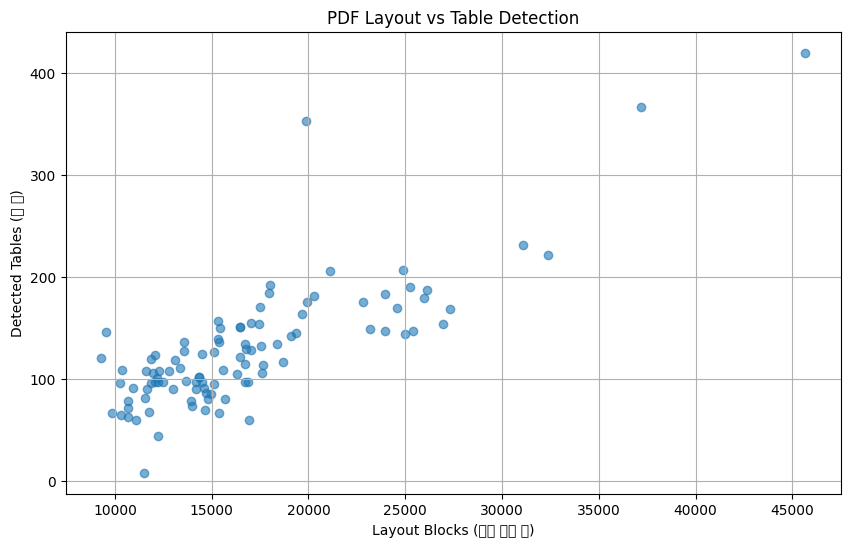

📄 OCR 비교 보고서 저장: /home/bhs1581/rag-rfp-system/outputs/structure_check/ocr_comparison.md


In [43]:
# =========================================================
# 📘 03_pdf_detailed_structure.ipynb
# Purpose : Detect PDF structural elements using pdfplumber + compare OCR gains
# =========================================================

import pdfplumber
import pytesseract
from pdf2image import convert_from_path
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 1️⃣ 경로 설정
# ---------------------------------------------------------
DATA_DIR = Path("/home/bhs1581/rag-rfp-system/data/pdf")
OUTPUT_DIR = Path("/home/bhs1581/rag-rfp-system/outputs/structure_check")
DETAIL_PATH = OUTPUT_DIR / "pdf_structure_details.csv"
REPORT_PATH = OUTPUT_DIR / "ocr_comparison.md"

# ---------------------------------------------------------
# 2️⃣ 함수 정의
# ---------------------------------------------------------
def analyze_pdf_structure(pdf_path):
    """pdfplumber를 이용한 구조 정보 추출"""
    try:
        with pdfplumber.open(pdf_path) as pdf:
            tables = 0
            blocks = 0
            fonts = []
            chars = 0

            for page in pdf.pages:
                # 표 탐지
                tables += len(page.find_tables())

                # 문자 정보
                chars += len(page.extract_text() or "")
                layout = page.extract_words()
                blocks += len(layout)
                
                # 폰트 크기
                try:
                    for c in page.chars:
                        if "size" in c:
                            fonts.append(c["size"])
                except:
                    pass

            font_range = round(max(fonts) - min(fonts), 2) if fonts else 0
            avg_chars = round(chars / max(1, len(pdf.pages)), 2)

            return {
                "pages": len(pdf.pages),
                "detected_tables": tables,
                "layout_blocks": blocks,
                "font_size_range": font_range,
                "avg_chars_per_page": avg_chars,
                "can_open": True
            }
    except Exception as e:
        return {"pages": 0, "detected_tables": 0, "layout_blocks": 0, 
                "font_size_range": 0, "avg_chars_per_page": 0, "can_open": False}

def ocr_text_length(pdf_path):
    """OCR 텍스트 길이 추출 (1~2페이지만 비교용)"""
    try:
        pages = convert_from_path(pdf_path, first_page=1, last_page=2)
        text = ""
        for page in pages:
            text += pytesseract.image_to_string(page, lang="kor+eng")
        return len(text)
    except Exception:
        return 0

# ---------------------------------------------------------
# 3️⃣ PDF 리스트 불러오기
# ---------------------------------------------------------
pdf_files = list(DATA_DIR.glob("*.pdf"))
print(f"총 {len(pdf_files)}개 PDF 분석 시작")

records = []
for file in tqdm(pdf_files, desc="PDF 구조 세부 분석 중"):
    base = analyze_pdf_structure(file)
    ocr_len = ocr_text_length(file)
    base["file_name"] = file.name
    base["ocr_gain_ratio"] = round(ocr_len / max(1, base["avg_chars_per_page"] * base["pages"]), 3)
    records.append(base)

df = pd.DataFrame(records)
df.to_csv(DETAIL_PATH, index=False, encoding="utf-8-sig")
print(f"\n✅ 세부 구조 분석 결과 저장: {DETAIL_PATH}")

# ---------------------------------------------------------
# 4️⃣ 시각화
# ---------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.scatter(df["layout_blocks"], df["detected_tables"], alpha=0.6)
plt.xlabel("Layout Blocks (문단 블록 수)")
plt.ylabel("Detected Tables (표 수)")
plt.title("PDF Layout vs Table Detection")
plt.grid(True)
plt.savefig(OUTPUT_DIR / "pdf_structure_scatter.png", dpi=200)
plt.show()

# ---------------------------------------------------------
# 5️⃣ OCR 비교 보고서
# ---------------------------------------------------------
report = []
report.append("# 🧩 PDF Structure & OCR Comparison\n")
report.append(f"총 {len(df)}개 문서 분석 완료\n")

report.append("\n## OCR Gain Ratio 상위 10개 문서\n")
report.append(df.sort_values("ocr_gain_ratio", ascending=False)
              .head(10)[["file_name","pages","ocr_gain_ratio","avg_chars_per_page"]]
              .to_markdown(index=False))

report.append("\n## 표(테이블) 감지 상위 10개 문서\n")
report.append(df.sort_values("detected_tables", ascending=False)
              .head(10)[["file_name","detected_tables","layout_blocks"]]
              .to_markdown(index=False))

with open(REPORT_PATH, "w", encoding="utf-8") as f:
    f.write("\n".join(report))

print(f"📄 OCR 비교 보고서 저장: {REPORT_PATH}")


# Task 4

In [46]:
# =========================================================
# 📘 04_text_chunking_and_quality.ipynb
# Purpose : Chunking strategy design & quality evaluation (no Java)
# =========================================================

import os
import re
import pandas as pd
from pathlib import Path
from tqdm import tqdm

# ---------------------------------------------------------
# 1️⃣ 경로 설정
# ---------------------------------------------------------
STRUCT_DIR = Path("/home/bhs1581/rag-rfp-system/outputs/structure_check")
TXT_FILES = list(STRUCT_DIR.glob("*.txt"))

CHUNK_DIR = STRUCT_DIR / "chunk_samples"
CHUNK_DIR.mkdir(exist_ok=True)
REPORT_PATH = STRUCT_DIR / "chunk_quality_report.csv"
MD_PATH = STRUCT_DIR / "chunking_summary.md"

# ---------------------------------------------------------
# 2️⃣ 청킹 함수
# ---------------------------------------------------------
def split_into_chunks(text, max_len=700, overlap=100):
    """문서를 문단 단위로 나누되, 최대 길이와 중복 비율 고려"""
    paragraphs = [p.strip() for p in text.split("\n") if len(p.strip()) > 0]
    chunks, current = [], ""

    for p in paragraphs:
        if len(current) + len(p) < max_len:
            current += p + " "
        else:
            chunks.append(current.strip())
            current = p[-overlap:] if overlap > 0 else p
    if current:
        chunks.append(current.strip())

    return chunks

# ---------------------------------------------------------
# 3️⃣ 품질 평가 함수 (Python-only)
# ---------------------------------------------------------
def evaluate_chunk_quality(chunk):
    """Okt 없이 의미 밀도와 언어 혼합도 추정"""
    # 단어 수 기반 의미 밀도 (명사·긴 단어 비율)
    words = re.findall(r"[가-힣A-Za-z]+", chunk)
    total_words = len(words)
    noun_like = len([w for w in words if len(w) > 2])  # 긴 단어를 정보 단어로 간주
    
    # 한글/영문 비율
    kor = len(re.findall(r"[가-힣]", chunk))
    eng = len(re.findall(r"[A-Za-z]", chunk))
    lang_ratio = round(kor / (eng + 1e-5), 3)
    
    return {
        "semantic_density": round(noun_like / max(1, total_words), 3),
        "language_mix_ratio": lang_ratio,
        "length": len(chunk)
    }

# ---------------------------------------------------------
# 4️⃣ 전체 문서 처리
# ---------------------------------------------------------
records = []

for file in tqdm(TXT_FILES, desc="청킹 및 품질 분석 중"):
    try:
        with open(file, encoding="utf-8") as f:
            text = f.read()

        chunks = split_into_chunks(text)
        chunk_scores = [evaluate_chunk_quality(c) for c in chunks]
        df_local = pd.DataFrame(chunk_scores)

        df_local["file_name"] = file.name
        df_local["chunk_count"] = len(chunks)
        df_local["avg_chunk_len"] = df_local["length"].mean()

        # 대표 청크 5개 저장
        sample_path = CHUNK_DIR / f"{file.stem}_chunks.txt"
        with open(sample_path, "w", encoding="utf-8") as out:
            for i, c in enumerate(chunks[:5]):
                out.write(f"[Chunk {i+1}]\n{c}\n\n")

        records.append({
            "file_name": file.name,
            "chunk_count": len(chunks),
            "avg_chunk_len": df_local["avg_chunk_len"].iloc[0],
            "avg_semantic_density": df_local["semantic_density"].mean(),
            "avg_language_mix_ratio": df_local["language_mix_ratio"].mean()
        })

    except Exception as e:
        print(f"⚠️ {file.name} 처리 실패: {e}")

# ---------------------------------------------------------
# 5️⃣ 리포트 저장
# ---------------------------------------------------------
df = pd.DataFrame(records)
df.to_csv(REPORT_PATH, index=False, encoding="utf-8-sig")
print(f"\n✅ 청크 품질 분석 결과 저장: {REPORT_PATH}")

# ---------------------------------------------------------
# 6️⃣ Markdown 요약
# ---------------------------------------------------------
report = []
report.append("# 🧩 Chunking Quality Report (Python-only)\n")
report.append(f"총 {len(df)}개 문서 분석 완료\n")

report.append("\n## 평균 통계 요약\n")
report.append(df.describe().to_markdown())

report.append("\n## 의미 밀도 상위 5개 문서\n")
report.append(df.sort_values("avg_semantic_density", ascending=False).head(5).to_markdown(index=False))

with open(MD_PATH, "w", encoding="utf-8") as f:
    f.write("\n".join(report))

print(f"📄 청킹 품질 리포트 저장: {MD_PATH}")


청킹 및 품질 분석 중:  32%|███▏      | 32/100 [00:00<00:01, 53.18it/s]

⚠️ 한국농수산식품유통공사_농산물가격안정기금 정부예산회계연계시스템 .txt 처리 실패: [Errno 36] File name too long: '/home/bhs1581/rag-rfp-system/outputs/structure_check/chunk_samples/한국농수산식품유통공사_농산물가격안정기금 정부예산회계연계시스템 _chunks.txt'
⚠️ 문화체육관광부 국립민속박물관_2024년 국립민속박물관 민속아카이브 자.txt 처리 실패: [Errno 36] File name too long: '/home/bhs1581/rag-rfp-system/outputs/structure_check/chunk_samples/문화체육관광부 국립민속박물관_2024년 국립민속박물관 민속아카이브 자_chunks.txt'


청킹 및 품질 분석 중:  50%|█████     | 50/100 [00:01<00:00, 50.41it/s]

⚠️ 한국로봇산업진흥원_한국로봇산업진흥원 사업관리시스템 온라인평가 .txt 처리 실패: [Errno 36] File name too long: '/home/bhs1581/rag-rfp-system/outputs/structure_check/chunk_samples/한국로봇산업진흥원_한국로봇산업진흥원 사업관리시스템 온라인평가 _chunks.txt'


청킹 및 품질 분석 중:  62%|██████▏   | 62/100 [00:01<00:00, 48.99it/s]

⚠️ 국립인천해양박물관_국립인천해양박물관 해양자료관리시스템 구축 용.txt 처리 실패: [Errno 36] File name too long: '/home/bhs1581/rag-rfp-system/outputs/structure_check/chunk_samples/국립인천해양박물관_국립인천해양박물관 해양자료관리시스템 구축 용_chunks.txt'


청킹 및 품질 분석 중: 100%|██████████| 100/100 [00:01<00:00, 51.06it/s]

⚠️ 한국발명진흥회 입찰공고_2024년 건설기술에 관한 특허·실용신안 활용실.txt 처리 실패: [Errno 36] File name too long: '/home/bhs1581/rag-rfp-system/outputs/structure_check/chunk_samples/한국발명진흥회 입찰공고_2024년 건설기술에 관한 특허·실용신안 활용실_chunks.txt'

✅ 청크 품질 분석 결과 저장: /home/bhs1581/rag-rfp-system/outputs/structure_check/chunk_quality_report.csv
📄 청킹 품질 리포트 저장: /home/bhs1581/rag-rfp-system/outputs/structure_check/chunking_summary.md


# Task 6

/home/bhs1581/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Embedding model loaded: sentence-transformers/distiluse-base-multilingual-cased-v2


임베딩 중: 100%|██████████| 95/95 [00:00<00:00, 14640.61it/s]


총 475개 청크 수집 완료


Batches: 100%|██████████| 15/15 [00:00<00:00, 17.56it/s]


임베딩 차원: 512

✅ 검색 품질 분석 결과 저장: /home/bhs1581/rag-rfp-system/outputs/structure_check/retrieval_quality_report.csv


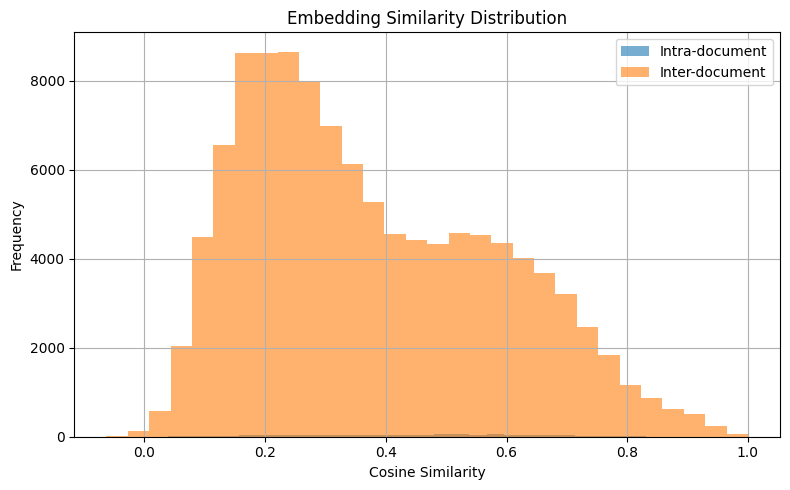

📄 요약 리포트 저장: /home/bhs1581/rag-rfp-system/outputs/structure_check/embedding_stats.md


In [47]:
# =========================================================
# 📘 05_retrieval_quality_analysis.ipynb
# Purpose : Embedding & retrieval performance correlation
# =========================================================

import os
import re
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 1️⃣ 경로 설정
# ---------------------------------------------------------
STRUCT_DIR = Path("/home/bhs1581/rag-rfp-system/outputs/structure_check")
CHUNK_DIR = STRUCT_DIR / "chunk_samples"
QUALITY_PATH = STRUCT_DIR / "chunk_quality_report.csv"
REPORT_PATH = STRUCT_DIR / "retrieval_quality_report.csv"
MD_PATH = STRUCT_DIR / "embedding_stats.md"

# ---------------------------------------------------------
# 2️⃣ 모델 로드
# ---------------------------------------------------------
model_name = "sentence-transformers/distiluse-base-multilingual-cased-v2"
model = SentenceTransformer(model_name)
print(f"✅ Embedding model loaded: {model_name}")

# ---------------------------------------------------------
# 3️⃣ 청크 데이터 수집
# ---------------------------------------------------------
chunk_data = []
for file in tqdm(list(CHUNK_DIR.glob("*.txt")), desc="임베딩 중"):
    with open(file, encoding="utf-8") as f:
        chunks = [c.strip() for c in f.read().split("\n\n") if len(c.strip()) > 50]
        for i, chunk in enumerate(chunks):
            chunk_data.append({"file_name": file.stem, "chunk_id": i, "text": chunk})

df_chunks = pd.DataFrame(chunk_data)
print(f"총 {len(df_chunks)}개 청크 수집 완료")

# ---------------------------------------------------------
# 4️⃣ 임베딩 계산
# ---------------------------------------------------------
embeddings = model.encode(df_chunks["text"].tolist(), convert_to_tensor=True, show_progress_bar=True)
emb_dim = embeddings.shape[1]
print(f"임베딩 차원: {emb_dim}")

# ---------------------------------------------------------
# 5️⃣ 유사도 계산
# ---------------------------------------------------------
cosine_sim_matrix = util.cos_sim(embeddings, embeddings).cpu().numpy()
similarity_mean = cosine_sim_matrix.mean()
similarity_std = cosine_sim_matrix.std()

# intra/inter 분리
df_chunks["doc_id"] = df_chunks["file_name"].factorize()[0]
intra_scores, inter_scores = [], []

for i in range(len(df_chunks)):
    for j in range(i+1, len(df_chunks)):
        sim = cosine_sim_matrix[i, j]
        if df_chunks["doc_id"][i] == df_chunks["doc_id"][j]:
            intra_scores.append(sim)
        else:
            inter_scores.append(sim)

intra_mean = np.mean(intra_scores)
inter_mean = np.mean(inter_scores)

# ---------------------------------------------------------
# 6️⃣ 청크 품질과 유사도 상관 분석
# ---------------------------------------------------------
quality_df = pd.read_csv(QUALITY_PATH)
merged = df_chunks.merge(quality_df, on="file_name", how="left")

corr_density = merged["avg_semantic_density"].corr(pd.Series(intra_scores[:len(merged)]))
corr_length = merged["avg_chunk_len"].corr(pd.Series(intra_scores[:len(merged)]))

# ---------------------------------------------------------
# 7️⃣ 결과 요약 저장
# ---------------------------------------------------------
report_df = pd.DataFrame({
    "embedding_dim": [emb_dim],
    "similarity_mean": [similarity_mean],
    "similarity_std": [similarity_std],
    "intra_doc_sim": [intra_mean],
    "inter_doc_sim": [inter_mean],
    "semantic_density_corr": [corr_density],
    "avg_chunk_len_corr": [corr_length]
})

report_df.to_csv(REPORT_PATH, index=False, encoding="utf-8-sig")
print(f"\n✅ 검색 품질 분석 결과 저장: {REPORT_PATH}")

# ---------------------------------------------------------
# 8️⃣ 시각화
# ---------------------------------------------------------
plt.figure(figsize=(8,5))
plt.hist(intra_scores, bins=30, alpha=0.6, label="Intra-document")
plt.hist(inter_scores, bins=30, alpha=0.6, label="Inter-document")
plt.title("Embedding Similarity Distribution")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(STRUCT_DIR / "retrieval_similarity_hist.png", dpi=200)
plt.show()

# ---------------------------------------------------------
# 9️⃣ Markdown 요약
# ---------------------------------------------------------
md = []
md.append("# 🔍 Retrieval Quality Report\n")
md.append(f"- 임베딩 모델: `{model_name}`")
md.append(f"- 총 청크 수: {len(df_chunks)}")
md.append(f"- 임베딩 차원: {emb_dim}")
md.append("\n## 유사도 통계\n")
md.append(report_df.to_markdown(index=False))
md.append("\n## 시각화\n")
md.append("![Retrieval Similarity](retrieval_similarity_hist.png)")

with open(MD_PATH, "w", encoding="utf-8") as f:
    f.write("\n".join(md))

print(f"📄 요약 리포트 저장: {MD_PATH}")


In [49]:
# =========================================================
# 📘 06_rag_simulation.ipynb
# Purpose : End-to-End RAG simulation with retriever + generator
# =========================================================

from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.llms import HuggingFacePipeline
from langchain_core.prompts import ChatPromptTemplate

from transformers import pipeline
import pandas as pd
from pathlib import Path
from tqdm import tqdm

# ---------------------------------------------------------
# 1️⃣ 경로 설정
# ---------------------------------------------------------
STRUCT_DIR = Path("/home/bhs1581/rag-rfp-system/outputs/structure_check")
CHUNK_DIR = STRUCT_DIR / "chunk_samples"
RESULT_PATH = STRUCT_DIR / "rag_simulation_results.csv"
MD_PATH = STRUCT_DIR / "rag_summary.md"

# ---------------------------------------------------------
# 2️⃣ 임베딩 및 벡터 DB 로드
# ---------------------------------------------------------
EMBED_MODEL = "sentence-transformers/distiluse-base-multilingual-cased-v2"
embeddings = HuggingFaceEmbeddings(model_name=EMBED_MODEL)

# 문서 불러오기
texts, metadatas = [], []
for file in CHUNK_DIR.glob("*.txt"):
    with open(file, encoding="utf-8") as f:
        for i, chunk in enumerate(f.read().split("\n\n")):
            if len(chunk.strip()) > 50:
                texts.append(chunk.strip())
                metadatas.append({"source": file.name, "chunk_id": i})

# FAISS 인덱스 구축
db = FAISS.from_texts(texts, embeddings, metadatas=metadatas)
print(f"✅ {len(texts)}개 청크 임베딩 완료")

# ---------------------------------------------------------
# 3️⃣ Generator (LLM) 준비
# ---------------------------------------------------------
GEN_MODEL = "mistralai/Mistral-7B-Instruct-v0.2"
hf_gen = pipeline(
    "text-generation",
    model=GEN_MODEL,
    device_map="auto",
    torch_dtype="auto",
    max_new_tokens=256,
    temperature=0.3,
    repetition_penalty=1.1
)
llm = HuggingFacePipeline(pipeline=hf_gen)
print(f"✅ Generator 로드 완료: {GEN_MODEL}")

# ---------------------------------------------------------
# 4️⃣ RAG 프롬프트
# ---------------------------------------------------------
prompt = ChatPromptTemplate.from_template(
"""
당신은 RFP 문서를 분석하는 전문 AI 어시스턴트입니다.
다음 문서 발췌를 기반으로 질문에 대답하세요.
만약 근거가 부족하다면 “관련 내용을 찾을 수 없습니다.”라고 답변하세요.

[문서 발췌]
{context}

[질문]
{question}
"""
)

# ---------------------------------------------------------
# 5️⃣ 테스트 질문 셋
# ---------------------------------------------------------
queries = [
    "이 문서의 주요 사업 목적은 무엇인가요?",
    "계약 금액 또는 예산 관련 내용이 언급되어 있나요?",
    "주요 수행 기관이나 발주처는 어디인가요?",
    "사업 기간은 언제로 명시되어 있나요?",
]

# ---------------------------------------------------------
# 6️⃣ RAG 시뮬레이션
# ---------------------------------------------------------
results = []
for q in tqdm(queries, desc="질문 테스트 중"):
    docs = db.similarity_search(q, k=3)
    context = "\n".join([d.page_content for d in docs])
    chain_input = prompt.format(context=context, question=q)
    answer = llm.invoke(chain_input)
    
    results.append({
        "question": q,
        "retrieved_sources": [d.metadata["source"] for d in docs],
        "answer": answer
    })

# ---------------------------------------------------------
# 7️⃣ 결과 저장
# ---------------------------------------------------------
df = pd.DataFrame(results)
df.to_csv(RESULT_PATH, index=False, encoding="utf-8-sig")
print(f"\n✅ RAG 시뮬레이션 결과 저장: {RESULT_PATH}")

# ---------------------------------------------------------
# 8️⃣ Markdown 요약
# ---------------------------------------------------------
md = []
md.append("# 🤖 RAG End-to-End Simulation Report\n")
md.append(f"- Retriever: `{EMBED_MODEL}`")
md.append(f"- Generator: `{GEN_MODEL}`")
md.append(f"- 총 테스트 질문: {len(queries)}개\n")

for i, row in df.iterrows():
    md.append(f"### Q{i+1}. {row['question']}")
    md.append(f"**참조 문서:** {', '.join(row['retrieved_sources'][:2])}")
    md.append(f"**답변:** {row['answer']}\n")

with open(MD_PATH, "w", encoding="utf-8") as f:
    f.write("\n".join(md))

print(f"📄 시뮬레이션 요약 저장: {MD_PATH}")


/tmp/ipykernel_97279/2236580256.py:28: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name=EMBED_MODEL)
`torch_dtype` is deprecated! Use `dtype` instead!


✅ 475개 청크 임베딩 완료


Loading checkpoint shards: 100%|██████████| 3/3 [01:10<00:00, 23.39s/it]
Device set to use cuda:0
/tmp/ipykernel_97279/2236580256.py:56: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFacePipeline``.
  llm = HuggingFacePipeline(pipeline=hf_gen)


✅ Generator 로드 완료: mistralai/Mistral-7B-Instruct-v0.2


질문 테스트 중: 100%|██████████| 4/4 [00:32<00:00,  8.12s/it]


✅ RAG 시뮬레이션 결과 저장: /home/bhs1581/rag-rfp-system/outputs/structure_check/rag_simulation_results.csv
📄 시뮬레이션 요약 저장: /home/bhs1581/rag-rfp-system/outputs/structure_check/rag_summary.md
